# The Prediction Task of UK Road Safety Data

In this task, we want to design a prediction model for **fatal accident** in the UK road safety data [(link)](https://data.gov.uk/dataset/cb7ae6f0-4be6-4935-9277-47e5ce24a11f/road-safety-data). The dataset provide detailed road data about the circustances of personal injury road accidents in UK, the details of vehicles and the consequential casualties. In this work, I chose to work with data between **2015 to 2019**. Moreover, since the "casualties" part is the consequences of accident, so I chose to use the "accidents" and "vehicles" part to predict whether the accident is fatal or not.

In this task, I will first take a glimpse of the data distribution and takle the missing datas. After that, we will design the prediction model and discuss the important factors and some insights I found in the task.

### Table of contents
1. [Data Preprocessing](#preprocessing)
2. [Data Characteristics and Visualizations](#visualizations)
3. [Prediction Model](#model)
4. [Discussions and Conclusions](#conclusion)

## Data Preprocessing <a name="preprocessing"></a>

In [87]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

#### Here we obtain accidents data & vehicle data from 2015-2019 and take a quick look at the table.

In [88]:
# obtain accidents data 2015-2019
accidents = pd.concat([pd.read_csv(f, compression='zip', 
                                   low_memory=False) for f in glob.glob('*Accidents*.zip')])
print('Records:', accidents.shape[0], '\nColumns:', accidents.shape[1])
accidents.head()

Records: 646830 
Columns: 32


,Accident_Index,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,...,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident,LSOA_of_Accident_Location
0,201501BS70001,525130.0,180050.0,-0.198465,51.505538,1,3,1,1,12/01/2015,...,0,0,4,1,1,0,0,1,1,E01002825
1,201501BS70002,526530.0,178560.0,-0.178838,51.491836,1,3,1,1,12/01/2015,...,0,0,1,1,1,0,0,1,1,E01002820
2,201501BS70004,524610.0,181080.0,-0.205590,51.514910,1,3,1,1,12/01/2015,...,0,1,4,2,2,0,0,1,1,E01002833
3,201501BS70005,524420.0,181080.0,-0.208327,51.514952,1,3,1,1,13/01/2015,...,0,0,1,1,2,0,0,1,2,E01002874
4,201501BS70008,524630.0,179040.0,-0.206022,51.496572,1,2,2,1,09/01/2015,...,0,5,1,2,2,0,0,1,2,E01002814


In [89]:
# obtain vehicle data 2015-2019
vehicles = pd.concat([pd.read_csv(f, compression='zip') for f in glob.glob('*Vehicles*.zip')], 
                     sort=True)
print('Records:', vehicles.shape[0], '\nColumns:', vehicles.shape[1])
vehicles.head()

Records: 1192061 
Columns: 23


,1st_Point_of_Impact,Accident_Index,Age_Band_of_Driver,Age_of_Driver,Age_of_Vehicle,Driver_Home_Area_Type,Driver_IMD_Decile,Engine_Capacity_(CC),Hit_Object_in_Carriageway,Hit_Object_off_Carriageway,...,Sex_of_Driver,Skidding_and_Overturning,Towing_and_Articulation,Vehicle_IMD_Decile,Vehicle_Leaving_Carriageway,Vehicle_Location-Restricted_Lane,Vehicle_Manoeuvre,Vehicle_Reference,Vehicle_Type,Was_Vehicle_Left_Hand_Drive?
0,3,2016010000005,8,51,-1,1,3,-1,0,0,...,1,0,0,3,0,0,6,1,8,1
1,1,2016010000005,5,23,4,1,4,124,0,0,...,1,0,0,4,0,0,18,2,2,1
2,4,2016010000006,7,36,1,1,10,1461,10,0,...,2,2,0,10,1,0,18,1,9,1
3,1,2016010000008,5,24,5,1,8,1390,0,0,...,1,5,0,8,0,0,18,1,9,1
4,0,2016010000016,8,55,7,1,9,6692,0,0,...,1,0,0,9,0,0,18,1,11,1


#### Here we take a look at the info of accidents and vehicles.

In [90]:
accidents.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 646830 entries, 0 to 117535
Data columns (total 32 columns):
 #   Column                                       Non-Null Count   Dtype  
---  ------                                       --------------   -----  
 0   Accident_Index                               646830 non-null  object 
 1   Location_Easting_OSGR                        646694 non-null  float64
 2   Location_Northing_OSGR                       646694 non-null  float64
 3   Longitude                                    646684 non-null  float64
 4   Latitude                                     646684 non-null  float64
 5   Police_Force                                 646830 non-null  int64  
 6   Accident_Severity                            646830 non-null  int64  
 7   Number_of_Vehicles                           646830 non-null  int64  
 8   Number_of_Casualties                         646830 non-null  int64  
 9   Date                                         646830 non-nul

In [91]:
vehicles.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1192061 entries, 0 to 257844
Data columns (total 23 columns):
 #   Column                            Non-Null Count    Dtype 
---  ------                            --------------    ----- 
 0   1st_Point_of_Impact               1192061 non-null  int64 
 1   Accident_Index                    1192061 non-null  object
 2   Age_Band_of_Driver                1192061 non-null  int64 
 3   Age_of_Driver                     1192061 non-null  int64 
 4   Age_of_Vehicle                    1192061 non-null  int64 
 5   Driver_Home_Area_Type             1192061 non-null  int64 
 6   Driver_IMD_Decile                 1192061 non-null  int64 
 7   Engine_Capacity_(CC)              1192061 non-null  int64 
 8   Hit_Object_in_Carriageway         1192061 non-null  int64 
 9   Hit_Object_off_Carriageway        1192061 non-null  int64 
 10  Journey_Purpose_of_Driver         1192061 non-null  int64 
 11  Junction_Location                 1192061 non-null 

#### Turn data into correct format

In [92]:
# turn Date data to store in the correct format.
accidents['Date']= pd.to_datetime(accidents['Date'], format="%d/%m/%Y")

In [93]:
# turn the Time data into hour format
accidents['Hour'] = accidents['Time'].str[0:2]
accidents['Hour'] = pd.to_numeric(accidents['Hour'])
accidents = accidents.dropna(subset=['Hour'])
accidents['Hour'] = accidents['Hour'].astype('int')

#### Handling missing values

In [94]:
# Handling missing values
print('Proportion of Missing Values in Accidents Table:', 
      round(accidents.isna().sum().sum()/len(accidents), 3), '%')

Proportion of Missing Values in Accidents Table: 0.057 %


In [95]:
# drop NaN's
accidents = accidents.dropna()

# check if we have no NaN's 
accidents.isna().sum().sum()

0

In [96]:
print('Proportion of Missing Values in Vehicles Table:', 
      round(vehicles.isna().sum().sum()/len(vehicles),3), '%')

Proportion of Missing Values in Vehicles Table: 0.0 %


#### Turn the accident severity from fatal/serious/slight to fatal/non-fatal

In [97]:
# turn the accident severity from fatal/serious/slight to fatal/non-fatal
def fatalOrNot(severity):
    if severity == 1:
        return 1
    else:
        return 0

In [98]:
accidents['Fatal'] = accidents['Accident_Severity'].apply(fatalOrNot)

accidents = accidents.dropna(subset=['Fatal'])

In [99]:
accidents[['Accident_Severity', 'Fatal']]

,Accident_Severity,Fatal
0,3,0
1,3,0
2,3,0
3,3,0
4,2,0
...,...,...
111847,1,1
111848,1,1
111849,1,1
111850,1,1


## Data Characteristics and Simple Visualizations 
<a name="visualizations"></a>

** Fatal Accidents **
As we can see in the pie chart, the portion of the fatal accidents is relatively small, this may lead to data imbalance problem in the model prediction part. Hence in the future, we will focus more on the **precision/recall score or confusion matrix** instead of **accuracy score** as a metric since it will be misleading and usually high.

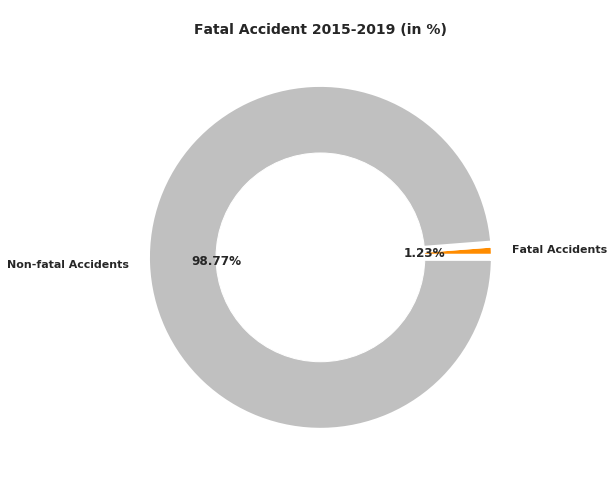

In [100]:
# assign the data
fatal   = accidents.Fatal.value_counts()[1]
nonfatal = accidents.Fatal.value_counts()[0]

names = ['Fatal Accidents','Non-fatal Accidents']
size  = [fatal, nonfatal]

# create a pie chart
plt.pie(x=size, labels=names, colors=['darkorange', 'silver'], 
        autopct='%1.2f%%', pctdistance=0.6, textprops=dict(fontweight='bold'),
        wedgeprops={'linewidth':7, 'edgecolor':'white'})

my_circle = plt.Circle((0,0), 0.6, color='white')

# plot the pie chart
fig = plt.gcf()
fig.set_size_inches(8,8)
fig.gca().add_artist(my_circle)
plt.title('\nFatal Accident 2015-2019 (in %)', fontsize=14, fontweight='bold')
plt.show()

**Co-relation between variables**

We also visulize the correlation between variables, as we can see that there is no strong correlations between **Accident Severity (Fatal)** to others.

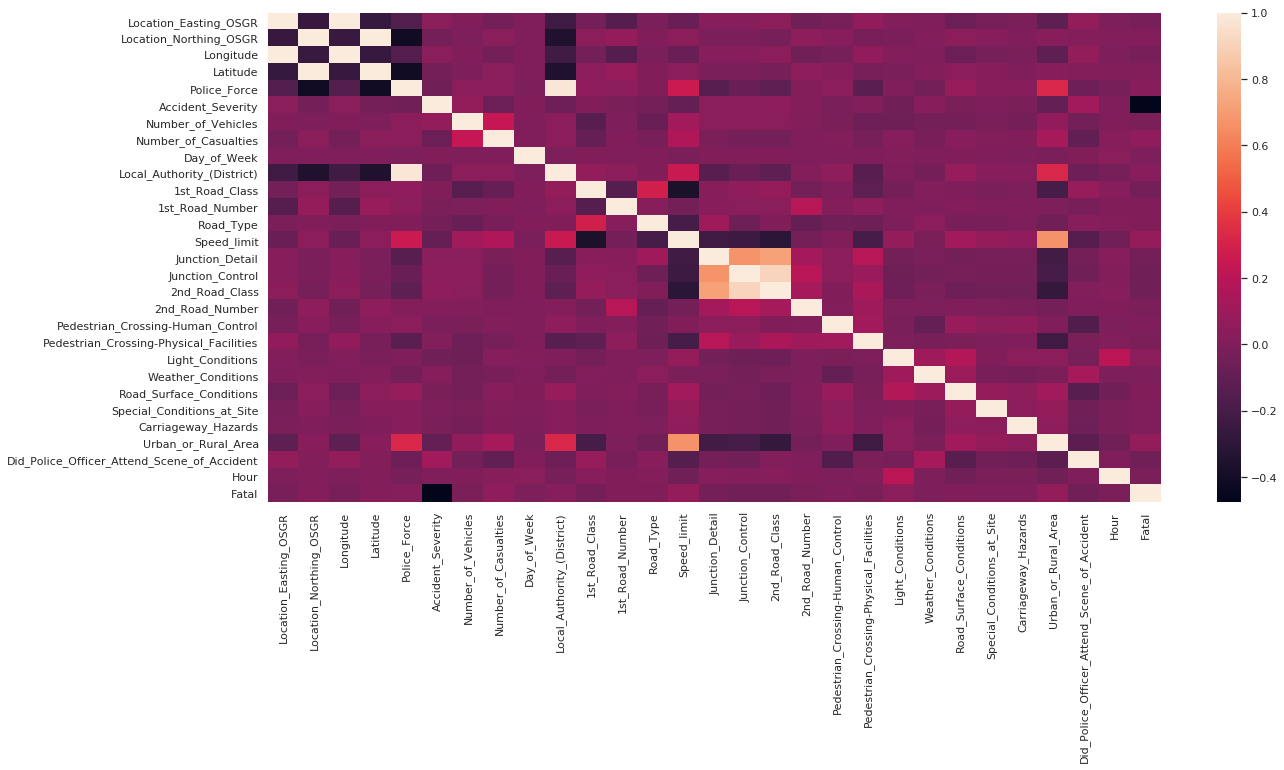

In [101]:
corr =  accidents.corr()
plt.subplots(figsize=(20,9))
sns.heatmap(corr)

We also want to know the fatalaties of each day, hence we do a simple visulization of graph to visualize the fatalaties per month in 2015 - 2019. As we can see in the graph, there is no obvious trend between date/year/month and fatalaties, hence we will remove the date feature in the future.

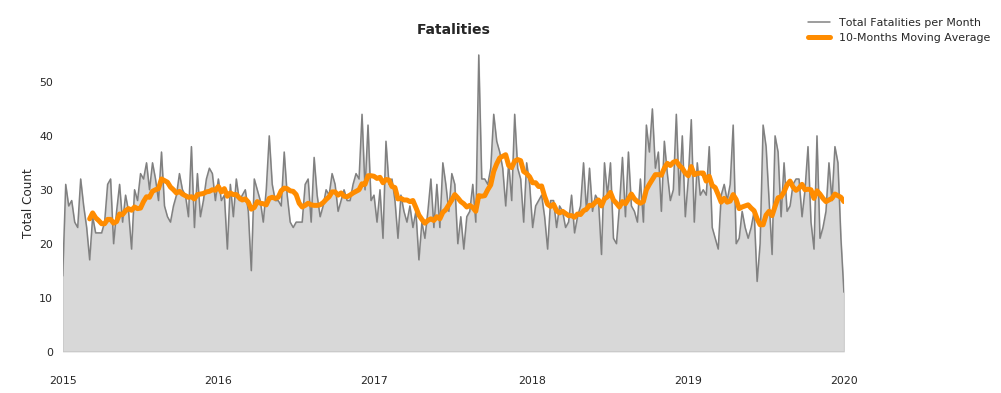

In [102]:
# set the criterium to slice the fatalaties
criteria = accidents['Fatal'] == 1
# create a new dataframe
weekly_fatalities = accidents.loc[criteria].set_index('Date').sort_index().resample('W').size()

sns.set_style('white')
fig, ax = plt.subplots(figsize=(14,6))

# plot
weekly_fatalities.plot(label='Total Fatalities per Month', color='grey', ax=ax)
plt.fill_between(x=weekly_fatalities.index, y1=weekly_fatalities.values, color='grey', alpha=0.3)
weekly_fatalities.rolling(window=10).mean()\
                           .plot(color='darkorange', linewidth=5, label='10-Months Moving Average', ax=ax)

ax.set_title('\nFatalities', fontsize=14, fontweight='bold')
ax.set(ylabel='\nTotal Count', xlabel='')
ax.legend(bbox_to_anchor=(1.2, 1.1), frameon=False)
sns.despine(ax=ax, top=True, right=True, left=True, bottom=True);

Here we drop the time, date, accident_severity since they've been replaced by other columns. After that we combine the two tables, accidents and vehicles. Then we try to handle categorical and numerical datas.

In [103]:
accidents = accidents.drop(columns=['Time', 'Accident_Severity', 'Date']) 

In [104]:
# combine the accidents with the vehicles table
df = pd.merge(accidents[['Accident_Index', 'Fatal', 'Speed_limit', 'Urban_or_Rural_Area', 
                         'Location_Easting_OSGR', 'Location_Northing_OSGR', 'Longitude', 'Latitude', 
                         'Police_Force', 'Number_of_Vehicles', 'Day_of_Week', 
                         'Local_Authority_(District)', 'Local_Authority_(Highway)', '1st_Road_Class',
                         '1st_Road_Number', 'Road_Type', 'Junction_Detail', 'Junction_Control',
                         '2nd_Road_Class', '2nd_Road_Number', 'Pedestrian_Crossing-Human_Control', 
                         'Pedestrian_Crossing-Physical_Facilities', 'Light_Conditions',
                         'Weather_Conditions', 'Road_Surface_Conditions', 'Special_Conditions_at_Site',
                         'Carriageway_Hazards', 'Did_Police_Officer_Attend_Scene_of_Accident']], 
              
              vehicles[['Accident_Index', 'Age_of_Driver', 'Age_of_Vehicle', 'Sex_of_Driver', 
                        'Engine_Capacity_(CC)', '1st_Point_of_Impact', 'Driver_Home_Area_Type',
                        'Driver_IMD_Decile', 'Hit_Object_in_Carriageway', 'Hit_Object_off_Carriageway', 
                        'Journey_Purpose_of_Driver', 'Junction_Location', 'Propulsion_Code', 'Skidding_and_Overturning',
                        'Towing_and_Articulation', 'Vehicle_IMD_Decile', 'Vehicle_Leaving_Carriageway',
                        'Vehicle_Location-Restricted_Lane', 'Vehicle_Manoeuvre', 'Vehicle_Reference',
                        'Vehicle_Type', 'Was_Vehicle_Left_Hand_Drive?']], 
              on='Accident_Index')
# df.isna().sum()

We deal with numerical and categorical data seperately, note that in the original setting, the **speed limit** was original a categorical data. However, we chose to treat it numerically since there's a trend in the speed category.

In [105]:
for col in ['Fatal', 'Urban_or_Rural_Area', 'Sex_of_Driver', 
             'Police_Force', 'Day_of_Week',
             'Local_Authority_(District)', 'Local_Authority_(Highway)', '1st_Road_Class',
             'Road_Type', 'Junction_Detail', 'Junction_Control',
             '2nd_Road_Class', 'Pedestrian_Crossing-Human_Control', 
             'Pedestrian_Crossing-Physical_Facilities', 'Light_Conditions',
             'Weather_Conditions', 'Road_Surface_Conditions', 'Special_Conditions_at_Site',
             'Carriageway_Hazards', 'Did_Police_Officer_Attend_Scene_of_Accident',
            'Vehicle_Manoeuvre', '1st_Point_of_Impact', 'Driver_Home_Area_Type',
            'Driver_IMD_Decile', 'Hit_Object_in_Carriageway', 'Hit_Object_off_Carriageway', 
            'Journey_Purpose_of_Driver', 'Junction_Location', 'Propulsion_Code', 'Skidding_and_Overturning',
            'Towing_and_Articulation', 'Vehicle_IMD_Decile', 'Vehicle_Leaving_Carriageway',
            'Vehicle_Location-Restricted_Lane', 'Vehicle_Reference',
            'Vehicle_Type', 'Was_Vehicle_Left_Hand_Drive?']:
    df[col] = df[col].astype('category')
    
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 963620 entries, 0 to 963619
Data columns (total 49 columns):
 #   Column                                       Non-Null Count   Dtype   
---  ------                                       --------------   -----   
 0   Accident_Index                               963620 non-null  object  
 1   Fatal                                        963620 non-null  category
 2   Speed_limit                                  963620 non-null  float64 
 3   Urban_or_Rural_Area                          963620 non-null  category
 4   Location_Easting_OSGR                        963620 non-null  float64 
 5   Location_Northing_OSGR                       963620 non-null  float64 
 6   Longitude                                    963620 non-null  float64 
 7   Latitude                                     963620 non-null  float64 
 8   Police_Force                                 963620 non-null  category
 9   Number_of_Vehicles                           963

Here we try to deal with numerical data and their outliers. Due to the model selection afterward, we will not normalize the numerical data. We eliminate the outliers of **age of vehicle** greater than 100 and **engine capacity** larger than 20000 from the obsevation of box plot.

In [106]:
num_cols = ['Age_of_Driver', 'Age_of_Vehicle', 'Engine_Capacity_(CC)', 'Speed_limit',
           'Location_Easting_OSGR', 'Location_Northing_OSGR', 'Longitude', 'Latitude',
           '1st_Road_Number', '2nd_Road_Number', 'Number_of_Vehicles']

In [107]:
df[num_cols].describe()

,Age_of_Driver,Age_of_Vehicle,Engine_Capacity_(CC),Speed_limit,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Latitude,1st_Road_Number,2nd_Road_Number,Number_of_Vehicles
count,963620.000000,963620.000000,963620.000000,963620.000000,963620.000000,963620.000000,963620.000000,963620.000000,963620.000000,963620.000000,963620.000000
mean,35.486646,5.643647,1411.444926,38.526641,448605.670649,275323.284225,-1.293993,52.366500,947.136339,345.032175,2.125894
std,20.547638,6.078941,1634.431493,14.368724,89957.659582,124568.487903,1.303597,1.124470,1761.933778,1234.281950,0.900108
min,-1.000000,-1.000000,-1.000000,-1.000000,90609.000000,10235.000000,-6.311427,49.912362,0.000000,-1.000000,1.000000
25%,23.000000,-1.000000,85.000000,30.000000,388638.000000,177254.000000,-2.170211,51.482015,0.000000,0.000000,2.000000
50%,35.000000,5.000000,1390.000000,30.000000,445552.000000,261533.500000,-1.320951,52.241223,59.000000,0.000000,2.000000
75%,50.000000,10.000000,1910.000000,50.000000,524595.000000,386110.000000,-0.200508,53.369072,635.000000,0.000000,2.000000
max,101.000000,105.000000,99999.000000,70.000000,655391.000000,656571.000000,1.759641,55.802413,9918.000000,9999.000000,37.000000


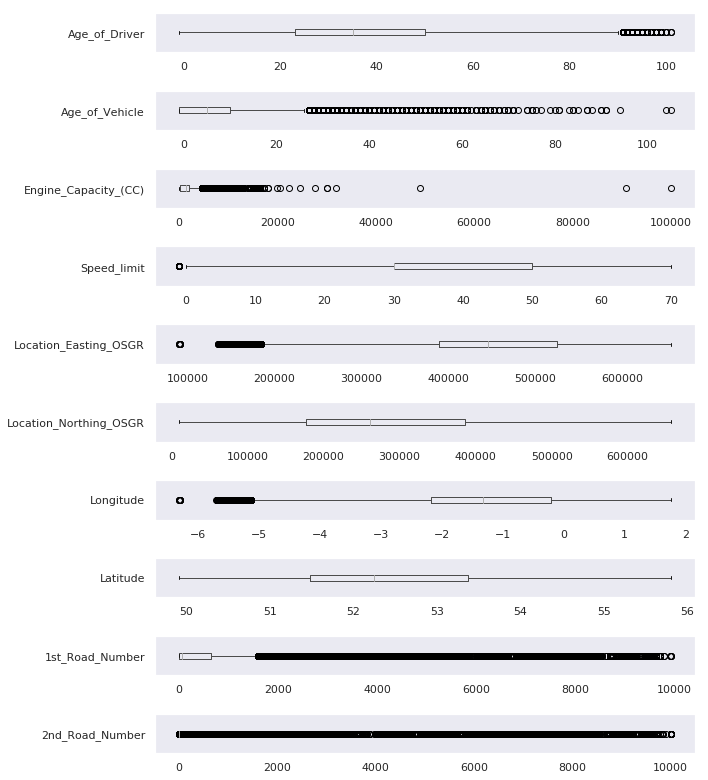

In [108]:
# plotting boxplots
sns.set(style='darkgrid')
fig, axes = plt.subplots(10,1, figsize=(10,11))

for ax, col in zip(axes, num_cols):
    df.boxplot(column=col, grid=False, vert=False, ax=ax)
    plt.tight_layout()

In [109]:
# phrasing condition
condition = (df['Engine_Capacity_(CC)'] < 20000)
condition2 = (df['Age_of_Vehicle'] < 100)

# keep only records that meet the condition and don't fall within extreme outliers
df = df[condition]
df = df[condition2]

In [110]:
# define categorical feature columns
cat_cols = [ 'Urban_or_Rural_Area', 'Sex_of_Driver', 
             'Police_Force', 'Day_of_Week',
             'Local_Authority_(District)', 'Local_Authority_(Highway)', '1st_Road_Class',
             'Road_Type', 'Junction_Detail', 'Junction_Control',
             '2nd_Road_Class', 'Pedestrian_Crossing-Human_Control', 
             'Pedestrian_Crossing-Physical_Facilities', 'Light_Conditions',
             'Weather_Conditions', 'Road_Surface_Conditions', 'Special_Conditions_at_Site',
             'Carriageway_Hazards', 'Did_Police_Officer_Attend_Scene_of_Accident',
            'Vehicle_Manoeuvre', '1st_Point_of_Impact', 'Driver_Home_Area_Type',
            'Driver_IMD_Decile', 'Hit_Object_in_Carriageway', 'Hit_Object_off_Carriageway', 
            'Journey_Purpose_of_Driver', 'Junction_Location', 'Propulsion_Code', 'Skidding_and_Overturning',
            'Towing_and_Articulation', 'Vehicle_IMD_Decile', 'Vehicle_Leaving_Carriageway',
            'Vehicle_Location-Restricted_Lane', 'Vehicle_Reference',
            'Vehicle_Type', 'Was_Vehicle_Left_Hand_Drive?']

# define target col
target_col = ['Fatal']

# cols = cat_cols + num_cols_scaled + target_col
cols = cat_cols + num_cols + target_col

# copy dataframe
df_model = df[cols].copy()
df_model.shape

(963608, 48)

In [111]:
# we turn all categorical features into one hot features
dummies = pd.get_dummies(df_model[cat_cols], drop_first=True)
df_model = pd.concat([df_model[num_cols], df_model[target_col], dummies], axis=1)
df_model.shape

(963608, 847)

In [112]:
df_model.isna().sum().sum()

0

### Prediction Model <a name="model"></a>

We define features as all the categorical and numerical features, and set fatal flag as our predition target. We split data into train/test with portion of 0.8 and 0.2 respectly.

In [113]:
features = df_model.drop(['Fatal'], axis=1)
target = df_model[['Fatal']]

In [114]:
from sklearn.model_selection import train_test_split
# split our data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2)

In [115]:
# count the portion of non-fatal & fatal
df_model['Fatal'].value_counts(normalize=True)

0    0.987153
1    0.012847
Name: Fatal, dtype: float64

**Model Selection**

Here we choose **random forest** classifier as our model due to the characteristics of our dataset and problem. The advantage of random forest are listed below: 1) It aggregates the votes from different decision trees to decide the final class of the test object and runs efficiently; 2) It can better deal with data with complicated features without doing dimension reduction; 3) It can decide the importance of different features; 4) It is not distance based and can handle varying ranges of features. (Therefore feature scaling is not required) 

we first use class weight technique to try to deal with imbalanced data

In [116]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import KFold, cross_val_score

In [117]:
# RandomForestClassifier with entropy + class_weight
forest_1 = RandomForestClassifier(random_state=4, criterion='entropy', n_jobs=8, class_weight='balanced')
# train
forest_1.fit(X_train, y_train)
# predict
y_test_preds  = forest_1.predict(X_test)
# evaluate
report = classification_report(y_test, y_test_preds)
print('Classification Report Random Forest - with Entropy and class_weight Parameter: \n', report)

Classification Report Random Forest - with Entropy and class_weight Parameter: 
               precision    recall  f1-score   support

           0       0.99      1.00      0.99    190240
           1       1.00      0.02      0.03      2482

    accuracy                           0.99    192722
   macro avg       0.99      0.51      0.51    192722
weighted avg       0.99      0.99      0.98    192722



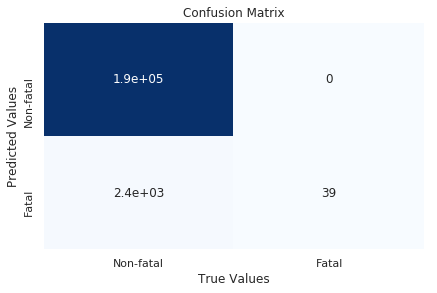

In [118]:
# create confusion matrix
matrix = confusion_matrix(y_test, y_test_preds)

class_names = df_model.Fatal.values
dataframe = pd.DataFrame(matrix, index=['Non-fatal', 'Fatal'], 
                         columns=['Non-fatal', 'Fatal'])
sns.heatmap(dataframe, annot=True, cbar=None, cmap='Blues')
plt.title('Confusion Matrix')
plt.tight_layout(), plt.xlabel('True Values'), plt.ylabel('Predicted Values')
plt.show()

As we can see in the result of recall/precision and F1-score. As expected, the recall of fatal class is really low since our model suffers from the **imbalanced** nature of our dataset. Hence we will need to deal with this problem.

#### Over-sampling (SMOTE)

![](https://raw.githubusercontent.com/rikunert/SMOTE_visualisation/master/SMOTE_R_visualisation_3.png)
SMOTE stands for Synthetic Minority Over-sampling Technique. SMOTE creates new synthetic points in order to have an equal balance of the classes. This is an alternative for solving the "class imbalance problems".


The advantages and features of SMOTE are listed below:
1) Solving the Class Imbalance: SMOTE creates synthetic points from the minority class in order to reach an equal balance between the minority and majority class.

2) Location of the synthetic points: SMOTE picks the distance between the closest neighbors of the minority class, in between these distances it creates synthetic points.

3) Final Effect: More information is retained since we didn't have to delete any rows unlike in random undersampling.

In [119]:
from imblearn.over_sampling import SMOTE

In [120]:
# view previous class distribution
print('Before Upsampling with SMOTE:'), print(target['Fatal'].value_counts())

# resample data ONLY using training data
X_resampled, y_resampled = SMOTE().fit_sample(X_train, y_train) 

# view synthetic sample class distribution
print('\nAfter Upsampling with SMOTE:'), print(y_resampled.value_counts())

Before Upsampling with SMOTE:
0    951229
1     12379
Name: Fatal, dtype: int64

After Upsampling with SMOTE:
Fatal
1        760989
0        760989
dtype: int64


(None, None)

In [121]:
# We perform another spliting over the over-sampled dataset.
X_train2, X_val2, y_train2, y_val2 = train_test_split(X_resampled, y_resampled, random_state=0)

In [122]:
# instantiate second RandomForestClassifier with entropy and SMOTE
forest_2 = RandomForestClassifier(random_state=4, criterion='entropy', n_jobs=16)
# train
forest_2.fit(X_train2, y_train2)
# predict
y_val_preds2 = forest_2.predict(X_val2)
# evaluate
report = classification_report(y_val2, y_val_preds2)
print('Classification Report Random Forest - with Entropy and SMOTE Upsampling: \n', report)

Classification Report Random Forest - with Entropy and SMOTE Upsampling: 
               precision    recall  f1-score   support

           0       0.99      1.00      0.99    189793
           1       1.00      0.99      0.99    190702

    accuracy                           0.99    380495
   macro avg       0.99      0.99      0.99    380495
weighted avg       0.99      0.99      0.99    380495



In [123]:
# predict
y_test_preds = forest_2.predict(X_test)
# evaluate
report = classification_report(y_test, y_test_preds)
print('Classification Report Random Forest - with Entropy and SMOTE Upsampling: \n', report)

Classification Report Random Forest - with Entropy and SMOTE Upsampling: 
               precision    recall  f1-score   support

           0       0.99      1.00      0.99    190240
           1       0.85      0.02      0.04      2482

    accuracy                           0.99    192722
   macro avg       0.92      0.51      0.51    192722
weighted avg       0.99      0.99      0.98    192722



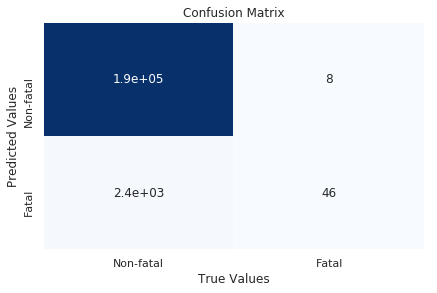

In [124]:
# create confusion matrix
matrix = confusion_matrix(y_test, y_test_preds)

# create dataframe
class_names = df_model.Fatal.values
dataframe = pd.DataFrame(matrix, index=['Non-fatal', 'Fatal'], 
                         columns=['Non-fatal', 'Fatal'])

# create heatmap
sns.heatmap(dataframe, annot=True, cbar=None, cmap='Blues')
plt.title('Confusion Matrix')
plt.tight_layout(), plt.xlabel('True Values'), plt.ylabel('Predicted Values')
plt.show()

In the inner training/validation set of the SMOTE method, the method seems to work well. However, there's only slightly improvement in the global testing set, the false positive rate is relativly high. We then try to do some parameter choosing.

In [128]:
forest_2 = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=True, random_state=42, verbose=0,
                       warm_start=False)
# train
forest_2.fit(X_train2, y_train2)
# predict
y_val_preds2 = forest_2.predict(X_val2)
# evaluate
report = classification_report(y_val2, y_val_preds2)
print('Classification Report Random Forest - with Entropy and SMOTE Upsampling: \n', report)


Classification Report Random Forest - with Entropy and SMOTE Upsampling: 
               precision    recall  f1-score   support

           0       0.99      1.00      0.99    189793
           1       1.00      0.99      0.99    190702

    accuracy                           0.99    380495
   macro avg       0.99      0.99      0.99    380495
weighted avg       0.99      0.99      0.99    380495



In [129]:
# predict
y_test_preds = forest_2.predict(X_test)
# evaluate
report = classification_report(y_test, y_test_preds)
print('Classification Report Random Forest - with Entropy and SMOTE Upsampling: \n', report)

Classification Report Random Forest - with Entropy and SMOTE Upsampling: 
               precision    recall  f1-score   support

           0       0.99      1.00      0.99    190240
           1       0.81      0.02      0.04      2482

    accuracy                           0.99    192722
   macro avg       0.90      0.51      0.52    192722
weighted avg       0.99      0.99      0.98    192722



After parameter choosing, we can see a slightly improvement in f1-score and precision, however the recall was still low, which means that the false negative is relatively high.

### Discussions and Conclusions <a name="conclusion"></a>

We are instrested in what features are more important, hence we visualize top 20s features in descending order.
Note that the number listed after the certain feature is one of the category of feature.
As we can see in the figure, the speed limit (numerical) is the most important feature.

Text(0.5, 0, 'Relative Feature Importance with Random Forest')

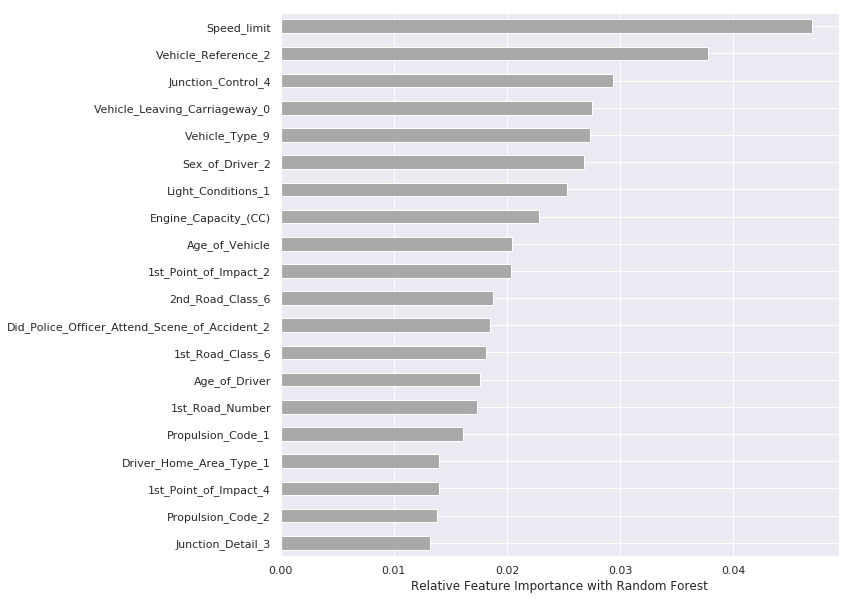

In [127]:
# plot the important features
feat_importances = pd.Series(forest_2.feature_importances_, index=features.columns)
feat_importances.nlargest(20).sort_values().plot(kind='barh', color='darkgrey', figsize=(10,10))
plt.xlabel('Relative Feature Importance with Random Forest')

In this task, we deal with the fatal prediction task of road safety data in UK. We select the random forest model as our classification model and deal with imbalanced data with weighted loss and over sampling. After that, we visualize the important features in this task. 